In [1]:
import sqlite3
import pandas as pd
import time

# List of CSV files to process
csv_files = ['datasets/salary_tracker_1MB.csv', 'datasets/salary_tracker_10MB.csv', 'datasets/salary_tracker_100MB.csv']

# Read queries from the file
def load_queries(file_path):
    queries = {}
    with open(file_path, 'r') as f:
        query_name = None
        query_content = []
        for line in f:
            line = line.strip()
            if line.startswith("--"):
                if query_name and query_content:
                    queries[query_name] = " ".join(query_content)
                query_name = line[2:].strip()  # Remove "--" and trim
                query_content = []
            else:
                query_content.append(line)
        if query_name and query_content:  # Add the last query
            queries[query_name] = " ".join(query_content)
    return queries

# Load queries from file
query_file = 'normalized_queries.txt'
queries = load_queries(query_file)

# Function to execute queries and measure execution time
def execute_queries(csv_files, queries):
    result = {}  # Dictionary to store the output for each file
    for csv_file in csv_files:
        print(f"Processing file: {csv_file}")
        
        # Initialize the database
        conn = sqlite3.connect(':memory:')
        cursor = conn.cursor()
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file)
        
        # Create tables based on the normalized schema
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Person (
                PersonID TEXT PRIMARY KEY,
                PersonName TEXT,
                BirthDate DATE,
                StillWorking TEXT
            )
        ''')

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS School (
                SchoolID TEXT PRIMARY KEY,
                SchoolName TEXT,
                SchoolCampus TEXT
            )
        ''')

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Department (
                DepartmentID TEXT PRIMARY KEY,
                DepartmentName TEXT
            )
        ''')

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Job (
                JobID TEXT PRIMARY KEY,
                JobTitle TEXT
            )
        ''')

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Employment (
                EmploymentID INTEGER PRIMARY KEY AUTOINCREMENT,
                PersonID TEXT,
                SchoolID TEXT,
                DepartmentID TEXT,
                JobID TEXT,
                Earnings INTEGER,
                EarningsYear INTEGER,
                FOREIGN KEY(PersonID) REFERENCES Person(PersonID),
                FOREIGN KEY(SchoolID) REFERENCES School(SchoolID),
                FOREIGN KEY(DepartmentID) REFERENCES Department(DepartmentID),
                FOREIGN KEY(JobID) REFERENCES Job(JobID)
            )
        ''')

        # Begin a transaction for batch inserts
        cursor.execute('BEGIN TRANSACTION;')

        try:
            # Use executemany for batch inserts to improve performance
            cursor.executemany('''
                INSERT OR REPLACE INTO Person (PersonID, PersonName, BirthDate, StillWorking) 
                VALUES (?, ?, ?, ?)
            ''', df[['PersonID', 'PersonName', 'BirthDate', 'StillWorking']].values.tolist())

            cursor.executemany('''
                INSERT OR REPLACE INTO School (SchoolID, SchoolName, SchoolCampus) 
                VALUES (?, ?, ?)
            ''', df[['SchoolID', 'SchoolName', 'SchoolCampus']].values.tolist())

            cursor.executemany('''
                INSERT OR REPLACE INTO Department (DepartmentID, DepartmentName) 
                VALUES (?, ?)
            ''', df[['DepartmentID', 'DepartmentName']].values.tolist())

            cursor.executemany('''
                INSERT OR REPLACE INTO Job (JobID, JobTitle) 
                VALUES (?, ?)
            ''', df[['JobID', 'JobTitle']].values.tolist())

            cursor.executemany('''
                INSERT INTO Employment (PersonID, SchoolID, DepartmentID, JobID, Earnings, EarningsYear) 
                VALUES (?, ?, ?, ?, ?, ?)
            ''', df[['PersonID', 'SchoolID', 'DepartmentID', 'JobID', 'Earnings', 'EarningsYear']].values.tolist())

            # Commit the transaction
            cursor.execute('COMMIT;')

        except sqlite3.DatabaseError as e:
            # Rollback in case of an error
            cursor.execute('ROLLBACK;')
            print(f"Error inserting data into tables: {e}")
            continue

        # Dictionary to store execution times for queries
        query_results = {}
        
        # Execute each query and measure execution time
        for query_name, query in queries.items():
            start_time = time.time()
            try:
                cursor.execute(query)
                execution_time = time.time() - start_time
                query_results[query_name] = f"Executed in {execution_time:.6f} seconds"
            except sqlite3.DatabaseError as e:
                query_results[query_name] = f"Error: {e}"

        # Store query results in the result dictionary for each file
        result[csv_file] = query_results
        
        # Close the connection to the database
        conn.close()

    return result

In [2]:
# Execute the queries and store results
execution_results = execute_queries(csv_files, queries)

Processing file: datasets/salary_tracker_1MB.csv
Processing file: datasets/salary_tracker_10MB.csv
Processing file: datasets/salary_tracker_100MB.csv


In [3]:
# Print the results
for csv_file, results in execution_results.items():
    print(f"Results for {csv_file}:")
    for query_name, result in results.items():
        print(f"{query_name}: {result}")

Results for datasets/salary_tracker_1MB.csv:
Query_1: Executed in 0.000974 seconds
Query_2: Executed in 0.000015 seconds
Query_3: Executed in 0.000035 seconds
Query_4: Executed in 0.002635 seconds
Query_5: Executed in 0.002018 seconds
Query_6: Executed in 0.002250 seconds
Results for datasets/salary_tracker_10MB.csv:
Query_1: Executed in 0.015565 seconds
Query_2: Executed in 0.000032 seconds
Query_3: Executed in 0.000033 seconds
Query_4: Executed in 0.023989 seconds
Query_5: Executed in 0.018017 seconds
Query_6: Executed in 0.027340 seconds
Results for datasets/salary_tracker_100MB.csv:
Query_1: Executed in 0.032044 seconds
Query_2: Executed in 0.000060 seconds
Query_3: Executed in 0.000050 seconds
Query_4: Executed in 0.267897 seconds
Query_5: Executed in 0.207658 seconds
Query_6: Executed in 0.270220 seconds


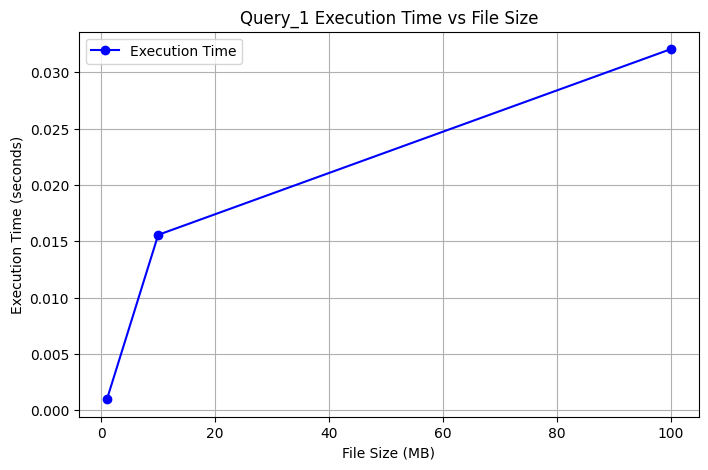

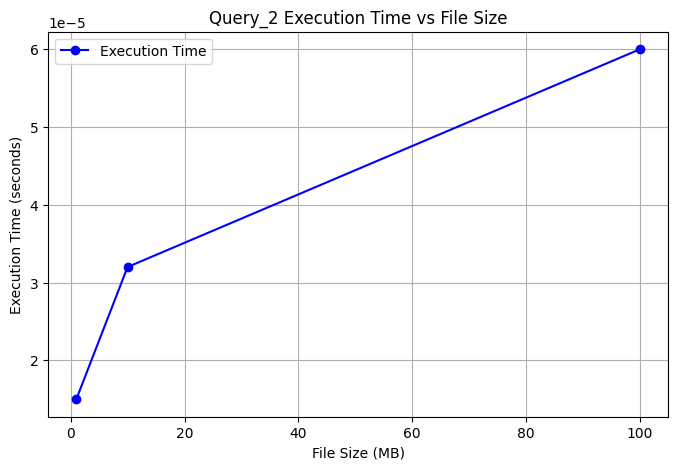

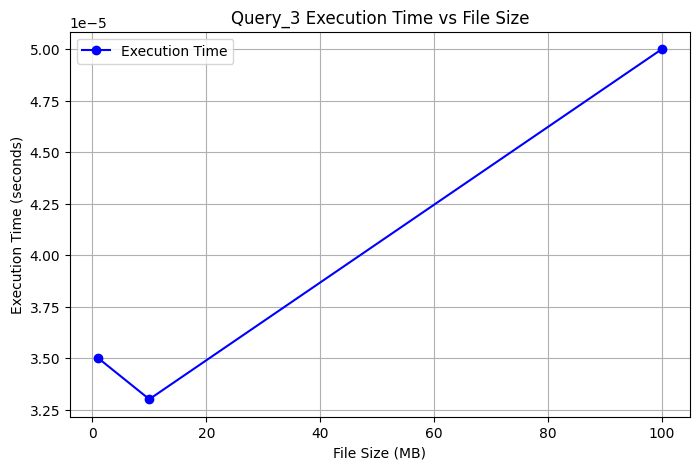

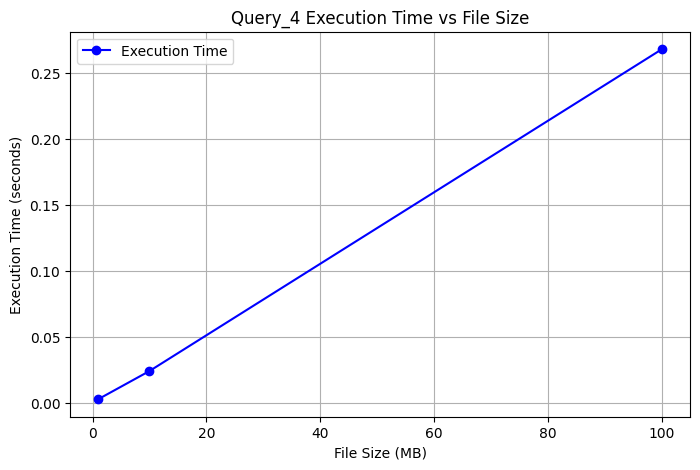

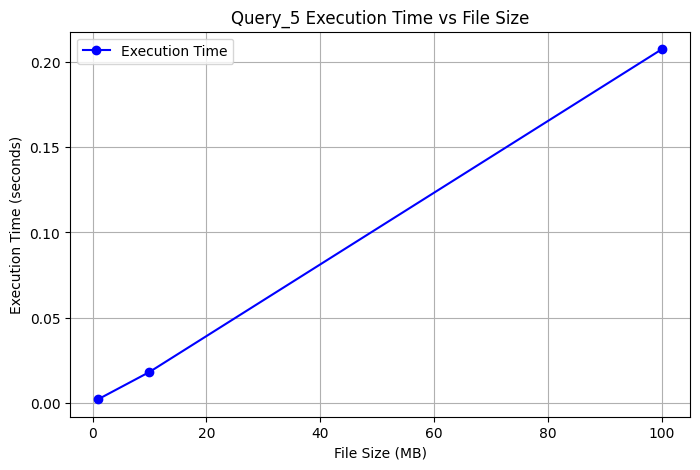

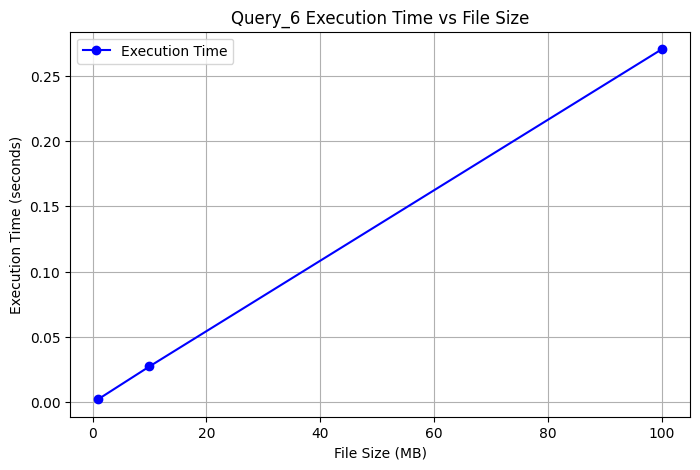

In [6]:
import matplotlib.pyplot as plt

# Define file sizes in MB
file_sizes = [1, 10, 100]

# Create a plot for each query
for query, times in query_times.items():
    plt.figure(figsize=(8, 5))  # Create a new figure for each query
    
    # Plot the execution times
    plt.plot(file_sizes, times, marker='o', label='Execution Time', color='b')
    
    # Adding titles and labels
    plt.title(f'{query} Execution Time vs File Size')
    plt.xlabel('File Size (MB)')
    plt.ylabel('Execution Time (seconds)')
    
    # Display the legend
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.show()

